# Bayesian Inference: A Computational Introduction

## 1. Theoretical Foundation

Bayesian inference is a method of statistical inference that uses Bayes' theorem to update the probability of a hypothesis as more evidence becomes available. Unlike frequentist approaches, Bayesian methods treat parameters as random variables with probability distributions.

### 1.1 Bayes' Theorem

The cornerstone of Bayesian inference is **Bayes' theorem**:

$$P(\theta | D) = \frac{P(D | \theta) \cdot P(\theta)}{P(D)}$$

Where:
- $P(\theta | D)$ is the **posterior distribution** — our updated belief about parameter $\theta$ after observing data $D$
- $P(D | \theta)$ is the **likelihood** — the probability of observing data $D$ given parameter $\theta$
- $P(\theta)$ is the **prior distribution** — our initial belief about $\theta$ before seeing data
- $P(D)$ is the **marginal likelihood** (evidence) — a normalizing constant

### 1.2 Conjugate Priors

A prior is said to be **conjugate** to a likelihood if the posterior distribution belongs to the same family as the prior. This property enables analytical solutions.

#### Beta-Binomial Conjugacy

For binomial likelihood with parameter $\theta$ (probability of success):

$$X | \theta \sim \text{Binomial}(n, \theta)$$

With a Beta prior:

$$\theta \sim \text{Beta}(\alpha, \beta)$$

The posterior is also Beta:

$$\theta | X \sim \text{Beta}(\alpha + X, \beta + n - X)$$

The Beta distribution PDF is:

$$f(\theta; \alpha, \beta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}$$

where $B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$ is the Beta function.

### 1.3 Posterior Predictive Distribution

To predict future observations $\tilde{X}$, we integrate over the posterior:

$$P(\tilde{X} | D) = \int P(\tilde{X} | \theta) P(\theta | D) \, d\theta$$

### 1.4 Credible Intervals

A $(1-\alpha)$ **credible interval** $[a, b]$ satisfies:

$$P(a \leq \theta \leq b | D) = 1 - \alpha$$

Unlike frequentist confidence intervals, credible intervals have a direct probabilistic interpretation.

## 2. Implementation

We will demonstrate Bayesian inference using the Beta-Binomial model to estimate the probability of success in a series of Bernoulli trials.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import beta as beta_func

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

### 2.1 Generate Synthetic Data

We simulate coin flips from a biased coin with true probability $\theta_{\text{true}} = 0.7$.

In [2]:
# True parameter (unknown in practice)
theta_true = 0.7

# Generate data: n Bernoulli trials
n_trials = 100
data = np.random.binomial(1, theta_true, n_trials)

# Summary statistics
n_successes = np.sum(data)
n_failures = n_trials - n_successes

print(f"Number of trials: {n_trials}")
print(f"Number of successes: {n_successes}")
print(f"Sample proportion: {n_successes/n_trials:.3f}")
print(f"True probability: {theta_true}")

Number of trials: 100
Number of successes: 70
Sample proportion: 0.700
True probability: 0.7


### 2.2 Define Prior, Likelihood, and Posterior

We compare three different priors:
1. **Uniform prior**: $\text{Beta}(1, 1)$ — no prior information
2. **Informative prior**: $\text{Beta}(5, 5)$ — centered at 0.5
3. **Strong prior**: $\text{Beta}(30, 10)$ — prior belief that $\theta \approx 0.75$

In [3]:
# Define priors
priors = {
    'Uniform (1, 1)': (1, 1),
    'Weakly Informative (5, 5)': (5, 5),
    'Strong Prior (30, 10)': (30, 10)
}

# Compute posteriors using conjugate update
posteriors = {}
for name, (alpha_prior, beta_prior) in priors.items():
    alpha_post = alpha_prior + n_successes
    beta_post = beta_prior + n_failures
    posteriors[name] = (alpha_post, beta_post)
    
    # Compute posterior statistics
    post_mean = alpha_post / (alpha_post + beta_post)
    post_mode = (alpha_post - 1) / (alpha_post + beta_post - 2) if alpha_post > 1 and beta_post > 1 else np.nan
    post_var = (alpha_post * beta_post) / ((alpha_post + beta_post)**2 * (alpha_post + beta_post + 1))
    
    print(f"\n{name}:")
    print(f"  Prior: Beta({alpha_prior}, {beta_prior})")
    print(f"  Posterior: Beta({alpha_post}, {beta_post})")
    print(f"  Posterior mean: {post_mean:.4f}")
    print(f"  Posterior mode: {post_mode:.4f}")
    print(f"  Posterior std: {np.sqrt(post_var):.4f}")


Uniform (1, 1):
  Prior: Beta(1, 1)
  Posterior: Beta(71, 31)
  Posterior mean: 0.6961
  Posterior mode: 0.7000
  Posterior std: 0.0453

Weakly Informative (5, 5):
  Prior: Beta(5, 5)
  Posterior: Beta(75, 35)
  Posterior mean: 0.6818
  Posterior mode: 0.6852
  Posterior std: 0.0442

Strong Prior (30, 10):
  Prior: Beta(30, 10)
  Posterior: Beta(100, 40)
  Posterior mean: 0.7143
  Posterior mode: 0.7174
  Posterior std: 0.0380


### 2.3 Visualization of Bayesian Updating

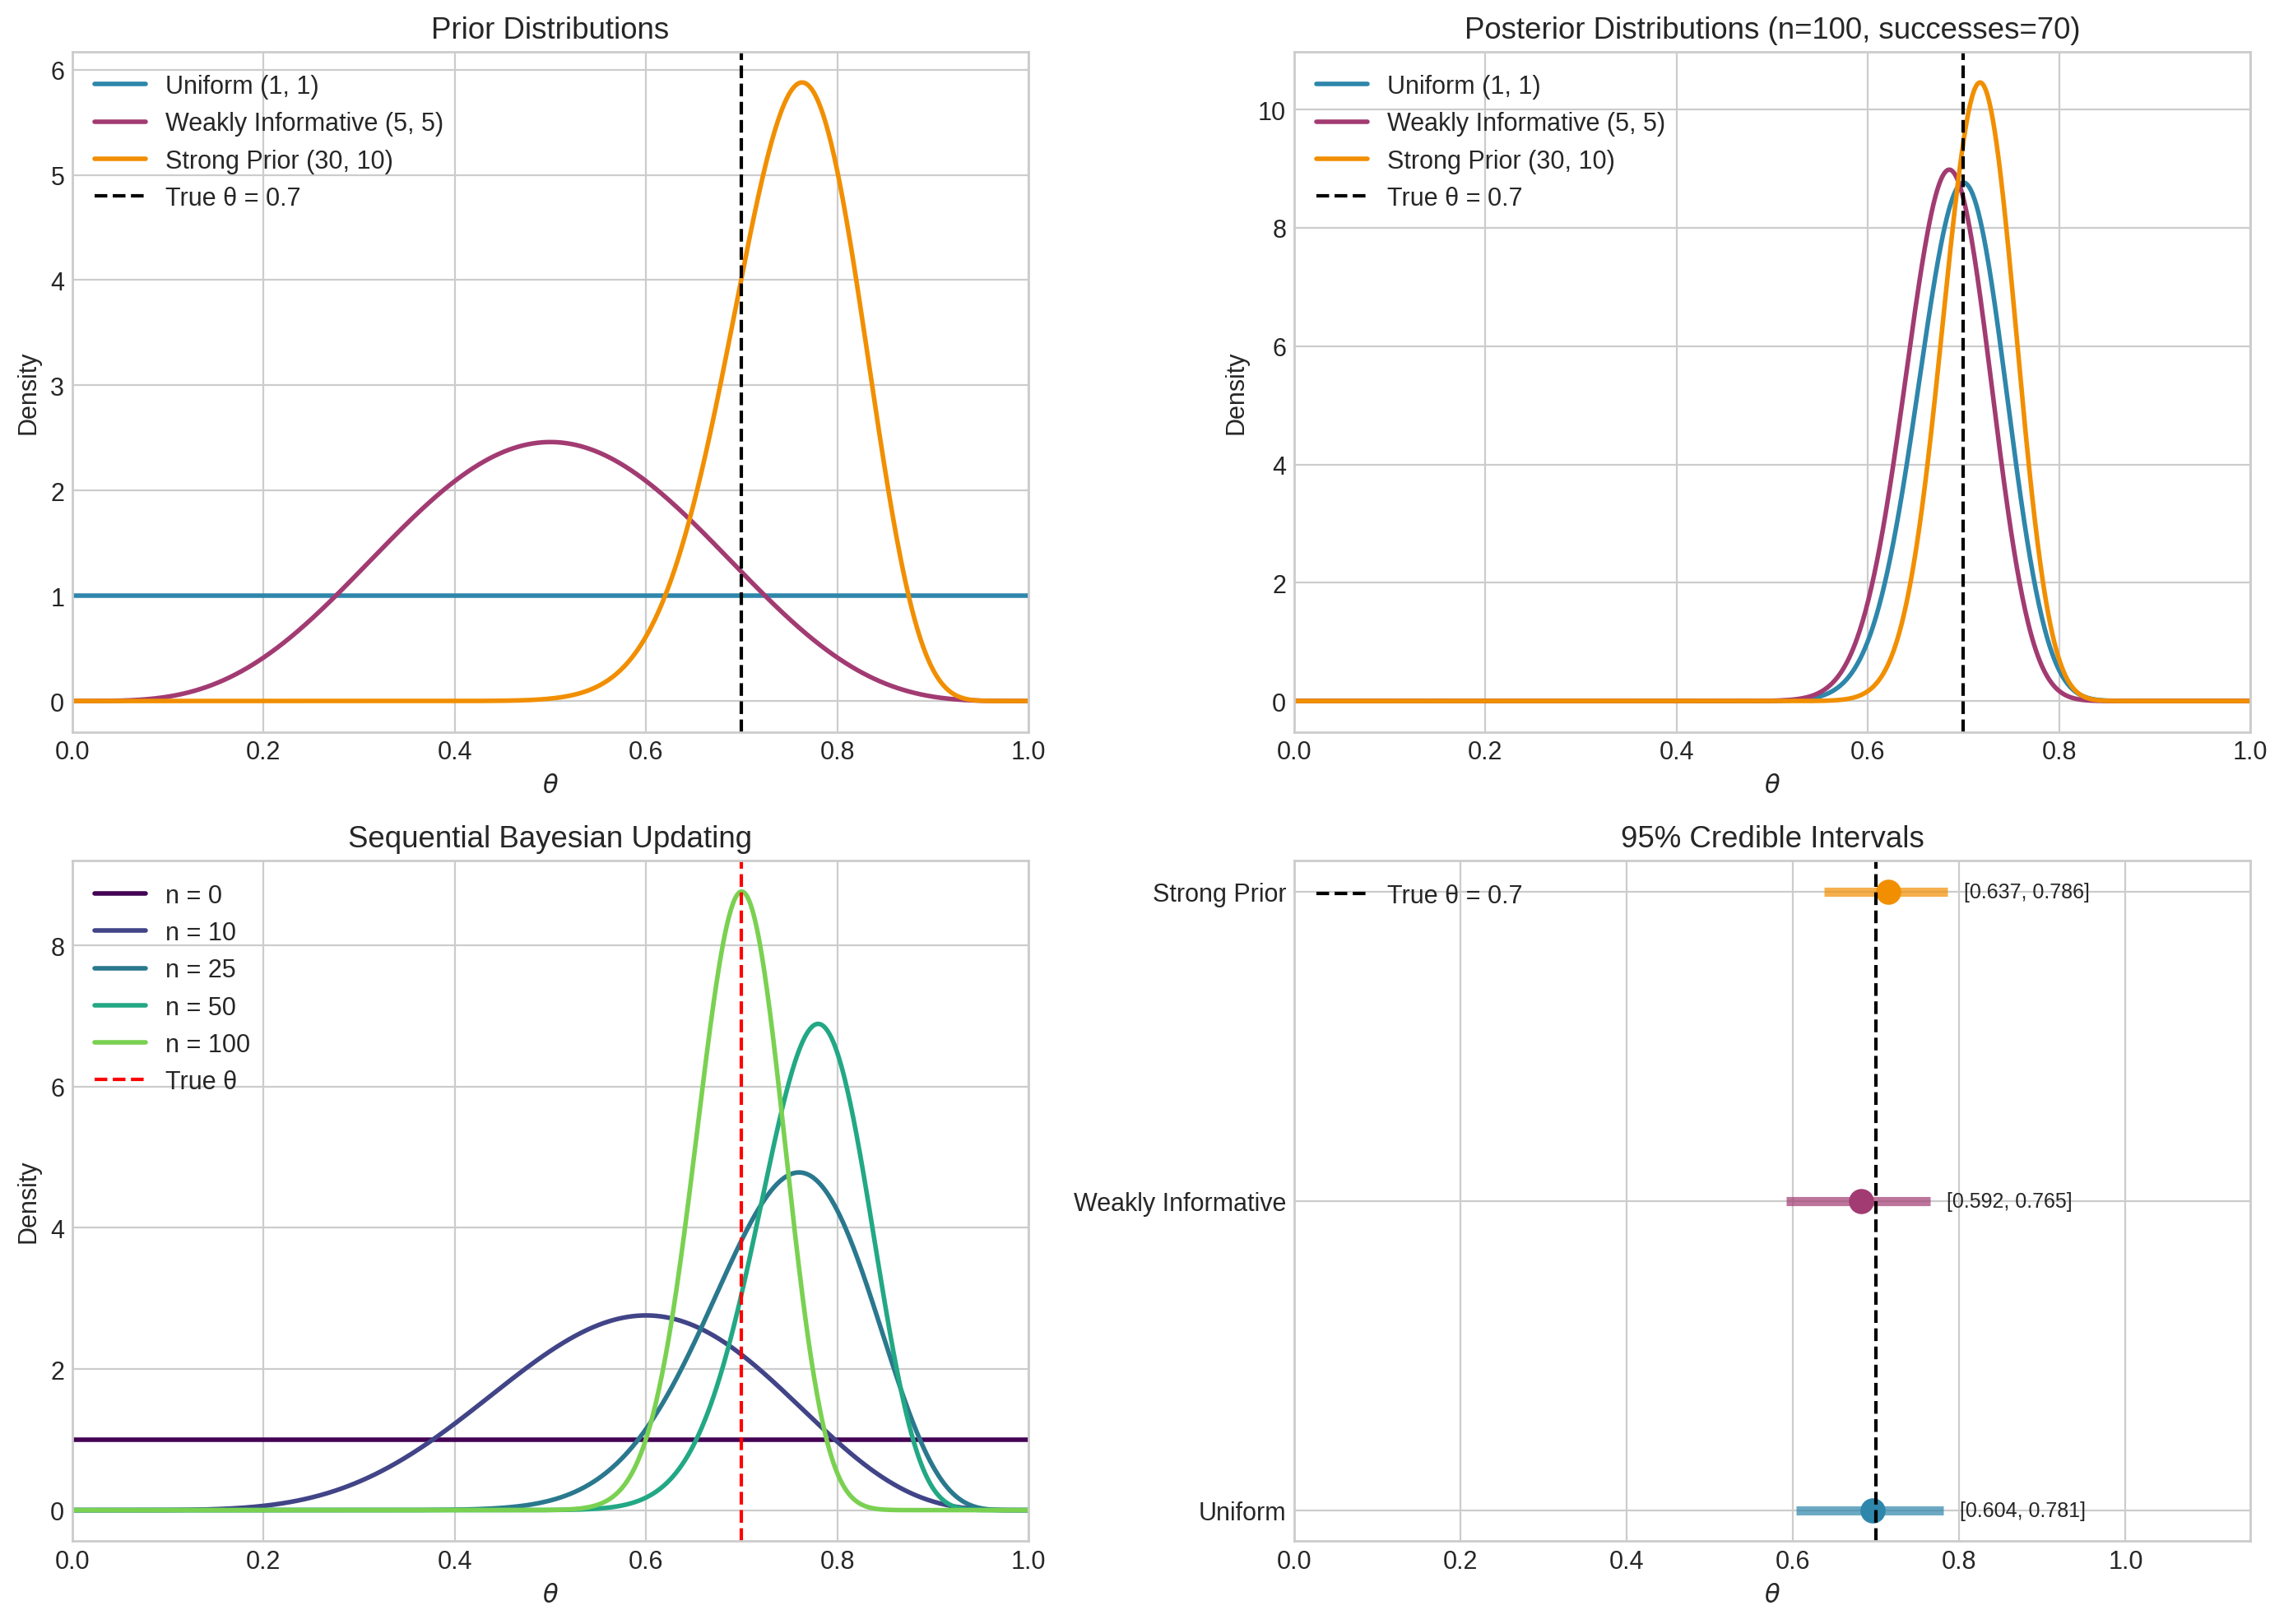


Plot saved to 'plot.png'


In [4]:
# Create theta grid for plotting
theta = np.linspace(0, 1, 1000)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Colors for different priors
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Plot 1: Prior distributions
ax1 = axes[0, 0]
for (name, (alpha, beta)), color in zip(priors.items(), colors):
    pdf = stats.beta.pdf(theta, alpha, beta)
    ax1.plot(theta, pdf, label=name, color=color, linewidth=2)
ax1.axvline(theta_true, color='black', linestyle='--', linewidth=1.5, label=f'True θ = {theta_true}')
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel('Density')
ax1.set_title('Prior Distributions')
ax1.legend(loc='upper left')
ax1.set_xlim(0, 1)

# Plot 2: Posterior distributions
ax2 = axes[0, 1]
for (name, (alpha, beta)), color in zip(posteriors.items(), colors):
    pdf = stats.beta.pdf(theta, alpha, beta)
    ax2.plot(theta, pdf, label=name, color=color, linewidth=2)
ax2.axvline(theta_true, color='black', linestyle='--', linewidth=1.5, label=f'True θ = {theta_true}')
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel('Density')
ax2.set_title(f'Posterior Distributions (n={n_trials}, successes={n_successes})')
ax2.legend(loc='upper left')
ax2.set_xlim(0, 1)

# Plot 3: Sequential Bayesian updating
ax3 = axes[1, 0]
alpha_seq, beta_seq = 1, 1  # Start with uniform prior
update_points = [0, 10, 25, 50, 100]
cmap = plt.cm.viridis

for i, n in enumerate(update_points):
    if n == 0:
        alpha_n, beta_n = alpha_seq, beta_seq
    else:
        successes_n = np.sum(data[:n])
        alpha_n = alpha_seq + successes_n
        beta_n = beta_seq + (n - successes_n)
    
    pdf = stats.beta.pdf(theta, alpha_n, beta_n)
    color = cmap(i / len(update_points))
    ax3.plot(theta, pdf, label=f'n = {n}', color=color, linewidth=2)

ax3.axvline(theta_true, color='red', linestyle='--', linewidth=1.5, label=f'True θ')
ax3.set_xlabel(r'$\theta$')
ax3.set_ylabel('Density')
ax3.set_title('Sequential Bayesian Updating')
ax3.legend(loc='upper left')
ax3.set_xlim(0, 1)

# Plot 4: 95% Credible intervals
ax4 = axes[1, 1]
y_positions = np.arange(len(posteriors))

for i, ((name, (alpha, beta)), color) in enumerate(zip(posteriors.items(), colors)):
    # Compute 95% credible interval
    ci_lower = stats.beta.ppf(0.025, alpha, beta)
    ci_upper = stats.beta.ppf(0.975, alpha, beta)
    mean = alpha / (alpha + beta)
    
    # Plot credible interval
    ax4.hlines(y=i, xmin=ci_lower, xmax=ci_upper, color=color, linewidth=4, alpha=0.7)
    ax4.plot(mean, i, 'o', color=color, markersize=10)
    
    # Annotate
    ax4.text(ci_upper + 0.02, i, f'[{ci_lower:.3f}, {ci_upper:.3f}]', 
             va='center', fontsize=9)

ax4.axvline(theta_true, color='black', linestyle='--', linewidth=1.5, label=f'True θ = {theta_true}')
ax4.set_yticks(y_positions)
ax4.set_yticklabels([name.split('(')[0].strip() for name in posteriors.keys()])
ax4.set_xlabel(r'$\theta$')
ax4.set_title('95% Credible Intervals')
ax4.set_xlim(0, 1.15)
ax4.legend(loc='upper left')

plt.tight_layout()
plt.savefig('bayesian_inference_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## 3. Posterior Predictive Distribution

We compute the probability of observing $k$ successes in the next $m$ trials, marginalizing over the posterior uncertainty in $\theta$.

In [5]:
def beta_binomial_pmf(k, n, alpha, beta):
    """
    Compute the Beta-Binomial PMF (posterior predictive for Binomial likelihood).
    
    P(k | n, alpha, beta) = C(n,k) * B(k+alpha, n-k+beta) / B(alpha, beta)
    """
    from scipy.special import comb, betaln
    log_pmf = (np.log(comb(n, k, exact=False)) + 
               betaln(k + alpha, n - k + beta) - 
               betaln(alpha, beta))
    return np.exp(log_pmf)

# Predict next m trials
m = 20
k_values = np.arange(0, m + 1)

# Using uniform prior posterior
alpha_post, beta_post = posteriors['Uniform (1, 1)']
predictive_pmf = [beta_binomial_pmf(k, m, alpha_post, beta_post) for k in k_values]

# Compute expected value and variance
expected_k = m * alpha_post / (alpha_post + beta_post)
variance_k = (m * alpha_post * beta_post * (alpha_post + beta_post + m)) / \
             ((alpha_post + beta_post)**2 * (alpha_post + beta_post + 1))

print(f"Posterior Predictive for next {m} trials:")
print(f"  Expected successes: {expected_k:.2f}")
print(f"  Standard deviation: {np.sqrt(variance_k):.2f}")
print(f"  Based on true θ = {theta_true}: expected = {m * theta_true:.2f}")

Posterior Predictive for next 20 trials:
  Expected successes: 13.92
  Standard deviation: 2.24
  Based on true θ = 0.7: expected = 14.00


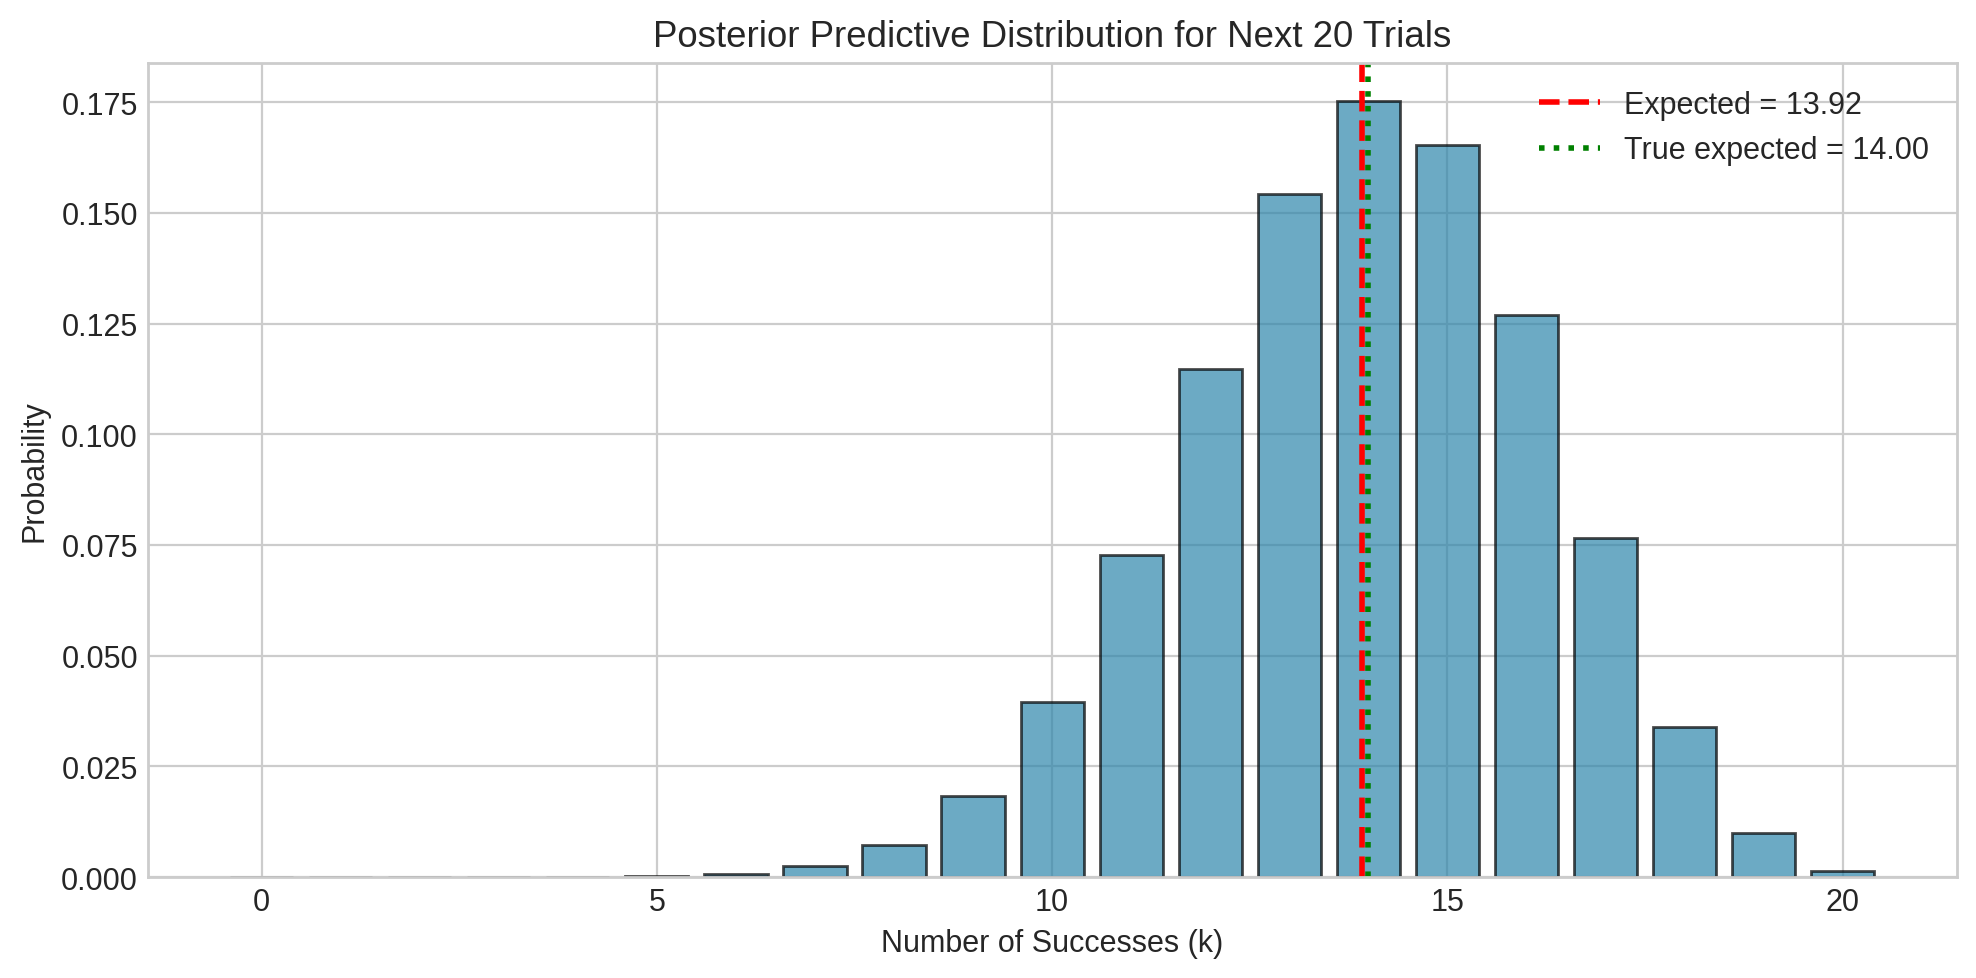

In [6]:
# Visualize posterior predictive
plt.figure(figsize=(10, 5))
plt.bar(k_values, predictive_pmf, color='#2E86AB', alpha=0.7, edgecolor='black')
plt.axvline(expected_k, color='red', linestyle='--', linewidth=2, 
            label=f'Expected = {expected_k:.2f}')
plt.axvline(m * theta_true, color='green', linestyle=':', linewidth=2,
            label=f'True expected = {m * theta_true:.2f}')
plt.xlabel('Number of Successes (k)')
plt.ylabel('Probability')
plt.title(f'Posterior Predictive Distribution for Next {m} Trials')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Model Comparison: Bayes Factor

The **Bayes factor** compares two models $M_1$ and $M_2$:

$$BF_{12} = \frac{P(D | M_1)}{P(D | M_2)}$$

For Beta-Binomial, the marginal likelihood is:

$$P(D | \alpha, \beta) = \binom{n}{k} \frac{B(k + \alpha, n - k + \beta)}{B(\alpha, \beta)}$$

In [7]:
from scipy.special import betaln, gammaln

def log_marginal_likelihood(k, n, alpha, beta):
    """
    Compute log marginal likelihood for Beta-Binomial model.
    """
    log_binom = gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)
    log_ml = log_binom + betaln(k + alpha, n - k + beta) - betaln(alpha, beta)
    return log_ml

# Compare priors
print("Bayes Factor Analysis:")
print("="*50)

log_mls = {}
for name, (alpha, beta) in priors.items():
    log_ml = log_marginal_likelihood(n_successes, n_trials, alpha, beta)
    log_mls[name] = log_ml
    print(f"{name}:")
    print(f"  Log marginal likelihood: {log_ml:.4f}")

# Compute Bayes factors relative to uniform prior
print("\nBayes Factors (relative to Uniform prior):")
baseline_log_ml = log_mls['Uniform (1, 1)']
for name, log_ml in log_mls.items():
    bf = np.exp(log_ml - baseline_log_ml)
    print(f"  {name}: BF = {bf:.4f}")

Bayes Factor Analysis:
Uniform (1, 1):
  Log marginal likelihood: -4.6151
Weakly Informative (5, 5):
  Log marginal likelihood: -4.3807
Strong Prior (30, 10):
  Log marginal likelihood: -3.2977

Bayes Factors (relative to Uniform prior):
  Uniform (1, 1): BF = 1.0000
  Weakly Informative (5, 5): BF = 1.2641
  Strong Prior (30, 10): BF = 3.7338


## 5. Numerical Integration: Grid Approximation

For non-conjugate models, we can use grid approximation to compute the posterior numerically.

In [8]:
def grid_approximation(data, prior_func, n_grid=1000):
    """
    Compute posterior using grid approximation.
    
    Parameters:
    -----------
    data : array-like
        Binary outcomes (0s and 1s)
    prior_func : callable
        Function that returns prior density at theta
    n_grid : int
        Number of grid points
    
    Returns:
    --------
    theta_grid : array
        Grid of theta values
    posterior : array
        Normalized posterior probabilities
    """
    # Create grid (avoiding 0 and 1 for numerical stability)
    theta_grid = np.linspace(0.001, 0.999, n_grid)
    
    # Compute prior
    prior = np.array([prior_func(t) for t in theta_grid])
    
    # Compute likelihood
    k = np.sum(data)
    n = len(data)
    likelihood = theta_grid**k * (1 - theta_grid)**(n - k)
    
    # Compute unnormalized posterior
    posterior_unnorm = likelihood * prior
    
    # Normalize (numerical integration via trapezoid rule)
    posterior = posterior_unnorm / np.trapz(posterior_unnorm, theta_grid)
    
    return theta_grid, posterior

# Define a custom non-standard prior (mixture of Betas)
def mixture_prior(theta):
    """Mixture of two Beta distributions."""
    return 0.5 * stats.beta.pdf(theta, 2, 8) + 0.5 * stats.beta.pdf(theta, 8, 2)

# Compute grid approximation
theta_grid, posterior_grid = grid_approximation(data, mixture_prior, n_grid=1000)

# Compute posterior mean and mode
posterior_mean_grid = np.trapz(theta_grid * posterior_grid, theta_grid)
posterior_mode_grid = theta_grid[np.argmax(posterior_grid)]

print("Grid Approximation with Mixture Prior:")
print(f"  Posterior mean: {posterior_mean_grid:.4f}")
print(f"  Posterior mode: {posterior_mode_grid:.4f}")

Grid Approximation with Mixture Prior:
  Posterior mean: 0.7086
  Posterior mode: 0.7123


/tmp/ipykernel_151121/398458641.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior = posterior_unnorm / np.trapz(posterior_unnorm, theta_grid)
/tmp/ipykernel_151121/398458641.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior_mean_grid = np.trapz(theta_grid * posterior_grid, theta_grid)


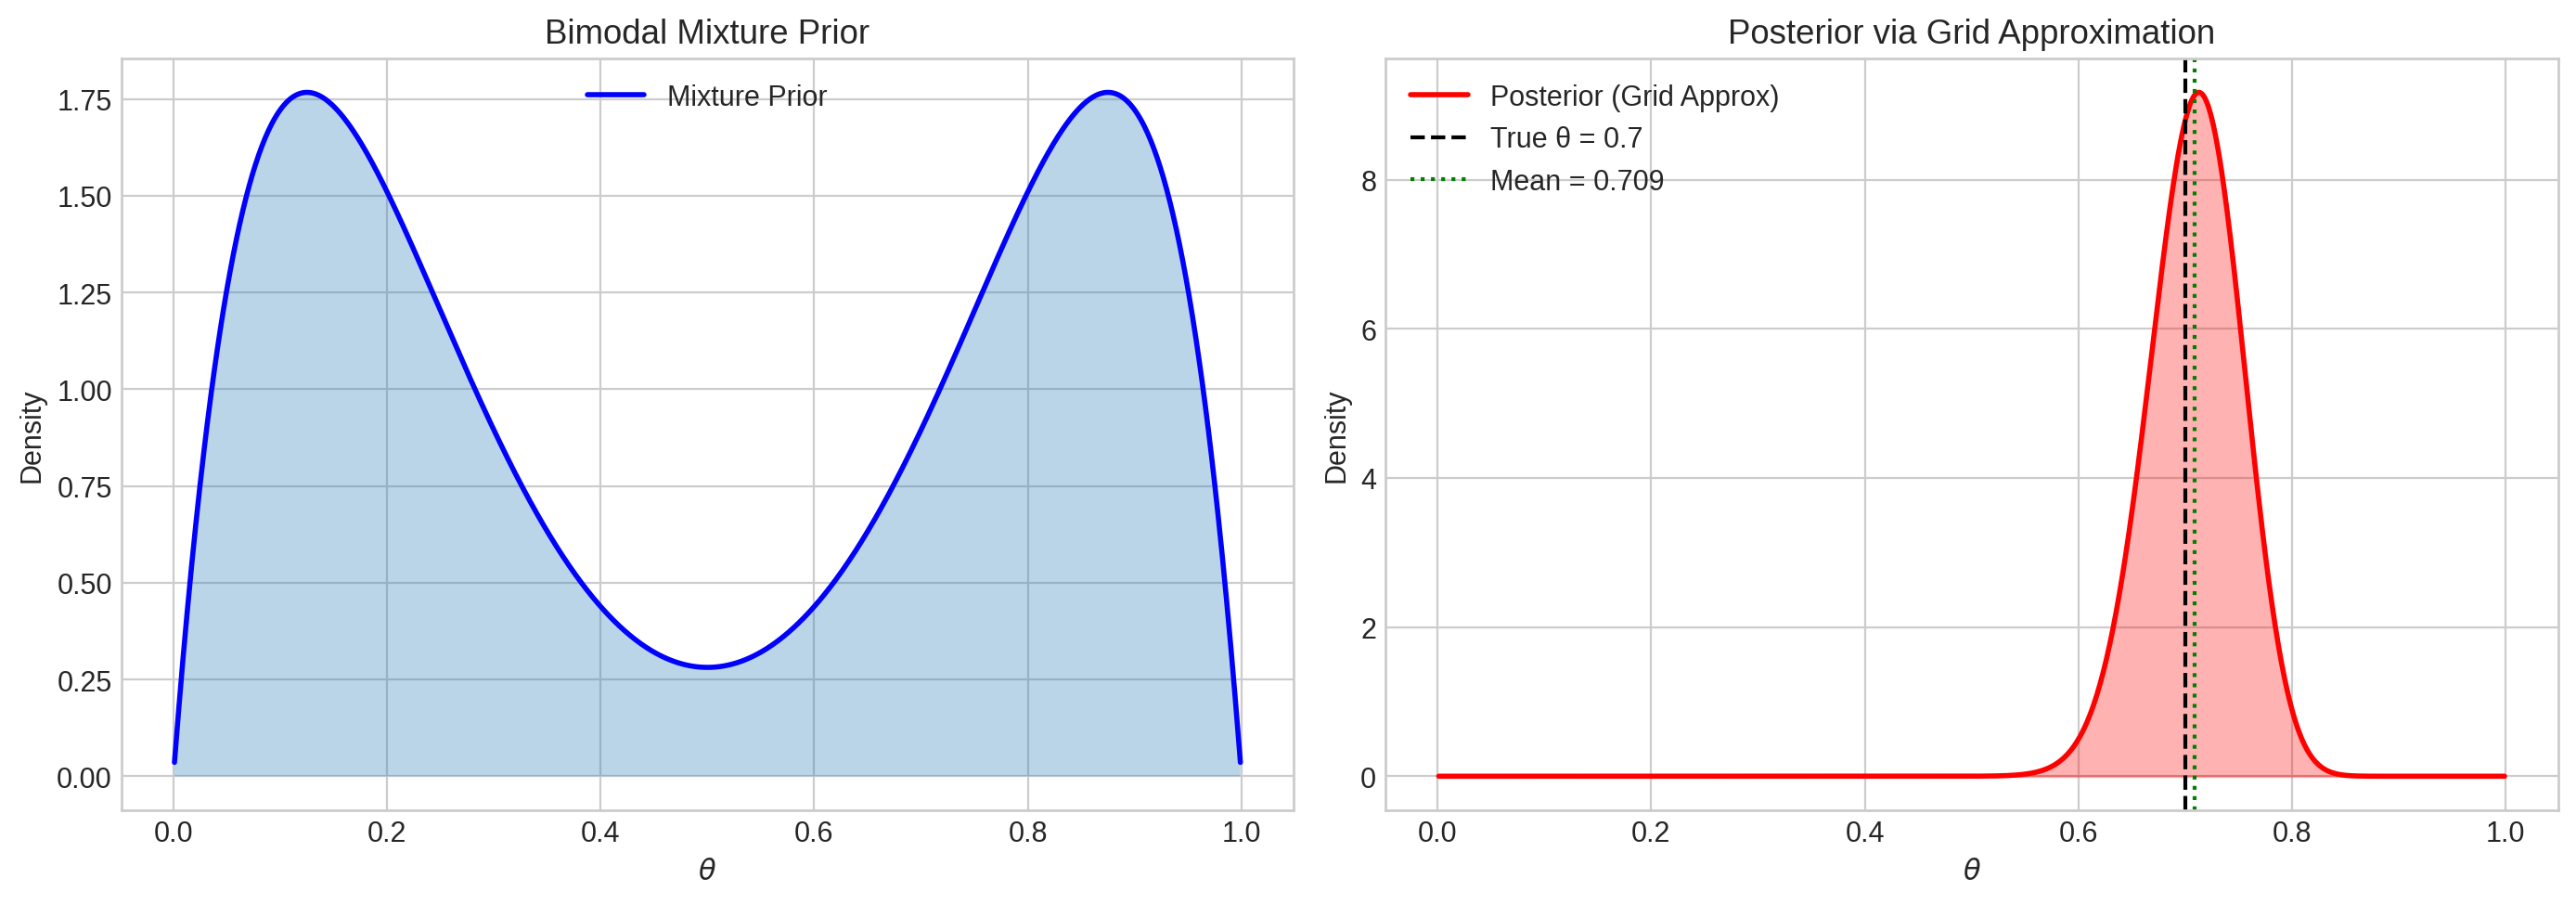

In [9]:
# Visualize grid approximation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot mixture prior
prior_values = [mixture_prior(t) for t in theta_grid]
axes[0].plot(theta_grid, prior_values, 'b-', linewidth=2, label='Mixture Prior')
axes[0].fill_between(theta_grid, prior_values, alpha=0.3)
axes[0].set_xlabel(r'$\theta$')
axes[0].set_ylabel('Density')
axes[0].set_title('Bimodal Mixture Prior')
axes[0].legend()

# Plot posterior from grid approximation
axes[1].plot(theta_grid, posterior_grid, 'r-', linewidth=2, label='Posterior (Grid Approx)')
axes[1].fill_between(theta_grid, posterior_grid, alpha=0.3, color='red')
axes[1].axvline(theta_true, color='black', linestyle='--', linewidth=1.5, 
                label=f'True θ = {theta_true}')
axes[1].axvline(posterior_mean_grid, color='green', linestyle=':', linewidth=1.5,
                label=f'Mean = {posterior_mean_grid:.3f}')
axes[1].set_xlabel(r'$\theta$')
axes[1].set_ylabel('Density')
axes[1].set_title('Posterior via Grid Approximation')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Summary

This notebook demonstrated key concepts in Bayesian inference:

1. **Bayes' theorem** provides a principled framework for updating beliefs given data
2. **Conjugate priors** (Beta-Binomial) enable analytical posterior computation
3. **Prior sensitivity**: Different priors lead to different posteriors, but with sufficient data, posteriors converge
4. **Credible intervals** provide direct probabilistic statements about parameter values
5. **Posterior predictive** distributions account for parameter uncertainty in predictions
6. **Bayes factors** enable formal model comparison
7. **Grid approximation** extends Bayesian methods to non-conjugate models

### Key Takeaways

- Bayesian methods naturally quantify uncertainty through probability distributions
- The choice of prior matters most when data are limited
- Conjugacy provides computational convenience but is not always realistic
- Numerical methods (grid, MCMC) extend Bayesian inference to complex models